In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import os
from matplotlib import cm
colors = list(cm.get_cmap('tab20').colors)

from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer


In [2]:
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}

def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    for labelid in classlabel:
        feature_names = vectorizer.get_feature_names_out()
        top_n = sorted(zip(classifier.feature_log_prob_[labelid], feature_names), reverse=True)[:n]
        for coef, feat in top_n:
            print("SDG {} : {:30}  {:.6}".format(labelid, feat, coef))
        print("")
def print_top_n_features(vectorizer, clf, class_labels, n=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(class_labels):
        top_n = np.argsort(clf.feature_log_prob_[i])[::-1][:n]
        print("%s: %s" % (class_label,
              " || ".join(feature_names[j] for j in top_n)))

In [3]:
data_dir = "/Users/yingli/Development/TopicsInDataScience/"
sdg_names = pd.read_csv(data_dir + "sdg_name_definition.csv")

text_file_name = "osdg-community-data-v2024-04-01.csv"
text_df = pd.read_csv(data_dir + text_file_name,sep = "\t",  quotechar='"')
text_df.drop(text_df.columns.values[0],axis = 1, inplace=True)
text_df = text_df.query("agreement > 0.5 and (labels_positive - labels_negative) > 2").reset_index(drop=True)

getting my google genAI API key

In [4]:
import google.generativeai as genai
genai.configure(api_key=os.environ["GOOGLEGENAI_KEY"])

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Obtaining embedding from google API

- This below cell took 80 minutes to run on my laptop, calling the google API. 
- I ran the code to generate the embedding for each of our text_df excerpt, and stored the resulting numpy array in a file (binary file), named 'genai_embedding_feature_20241118.npy'. 
- you can get this file from my drive (163 MB): https://drive.google.com/file/d/1pCo7kEETI4RUVicF9I2_0xWme2IFEdCH/view?usp=drive_link 


In [5]:
corpus = text_df.text
genai_model ="models/text-embedding-004"
embedding_feature = np.load('genai_embedding_feature_20241118.npy', allow_pickle = True)

In [6]:
embedding_feature.shape, text_df.shape

((26526, 768), (26526, 6))

In [7]:
corpus = text_df.text
X = embedding_feature
sdg_num = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(X, sdg_num, test_size=0.33, random_state=7)

In [8]:
X_train.shape, X_test.shape

((17772, 768), (8754, 768))

In [9]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

use_mlp_clf = MLPClassifier(random_state=1, max_iter=500, hidden_layer_sizes=(300,))\
    .fit(X_train_scaled, y_train)
y_pred = use_mlp_clf.predict(X_test_scaled)
print(metrics.classification_report(y_test,y_pred, digits = 4))


              precision    recall  f1-score   support

           1     0.8333    0.7732    0.8021       485
           2     0.8474    0.8700    0.8586       300
           3     0.9261    0.9580    0.9418       667
           4     0.9394    0.9362    0.9378       878
           5     0.9145    0.9631    0.9382       922
           6     0.9340    0.9115    0.9226       497
           7     0.8823    0.9310    0.9060       652
           8     0.7079    0.6000    0.6495       315
           9     0.8590    0.8770    0.8679       618
          10     0.7266    0.7445    0.7354       407
          11     0.8858    0.8634    0.8745       476
          12     0.8411    0.8127    0.8267       267
          13     0.9070    0.8405    0.8725       464
          14     0.9377    0.9275    0.9326       276
          15     0.9089    0.9254    0.9171       496
          16     0.9818    0.9894    0.9855      1034

    accuracy                         0.8950      8754
   macro avg     0.8770   

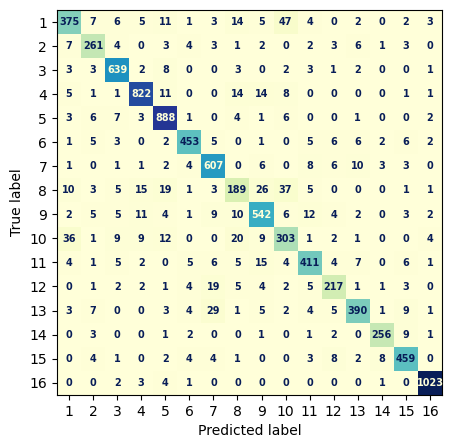

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax, cmap=plt.colormaps["YlGnBu"],colorbar=None)

In [11]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier

corpus = text_df.text
X = embedding_feature
y = text_df.sdg


label_binarizer = LabelBinarizer().fit(y)
y_onehot = label_binarizer.transform(y)
n_classes = len(label_binarizer.classes_)
class_names = [sdg_names[sdg_names["sdg"] == label_binarizer.classes_[i]].sdg_name.item() \
               for i in range(n_classes)]

X_train, X_test, y_train, y_test = \
    train_test_split(X, y_onehot, test_size=.33, random_state=7)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

ovr_mlp_clf = OneVsRestClassifier(MLPClassifier(random_state=0, max_iter=300)).fit(X_train_scaled,y_train)
y_score = ovr_mlp_clf.predict_proba(X_test_scaled)

/var/folders/j8/w88cxj05115byx3n9mnk572w0000gn/T/ipykernel_95398/1271586713.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = list(cm.get_cmap('tab20').colors)


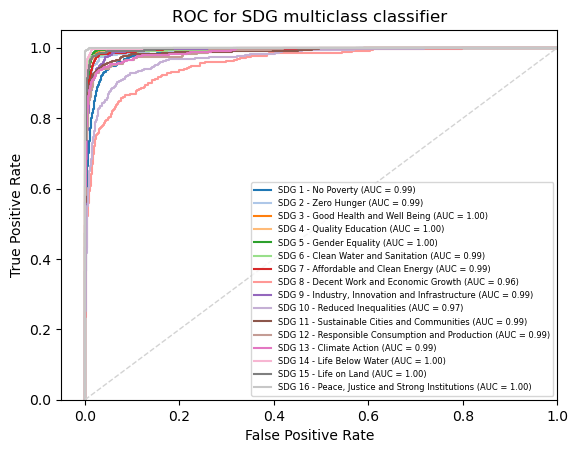

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_id in range(n_classes):
    fpr[class_id], tpr[class_id], _ = metrics.roc_curve(y_test[:, class_id], y_score[:, class_id]) # roc_curve works on binary
    roc_auc[class_id] = metrics.auc(fpr[class_id], tpr[class_id])

for class_id, color in zip(range(n_classes), colors):
    plt.plot(fpr[class_id], tpr[class_id], color=color, lw=1.5,alpha = 1, 
             label='SDG {0} - {1} (AUC = {2:0.2f})'
             ''.format(class_id+1, class_names[class_id], roc_auc[class_id]))
plt.plot([0, 1], [0, 1], '--', lw=1, color="lightgrey")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for SDG multiclass classifier')
plt.legend(loc="lower right", fontsize=6)
plt.show()